In order to handle class imbalance, the training set will be balanced by using an over sampling method in python's imbalanced-learn library. The categorical columns will be transformed with a One-Hot encoding technique because they are nominal and do not have any form of ordering, the model will then be tested on an imbalanced test set to evaluate the algorithms performance in identifying both classes. A tree-based algorithm will be used to build the model because they are able to model the non-linear relationship between features in the dataset and they are not usually affected by features with outliers. To ensure proper evaluation on the test set, a stratified sampling technique will be used to split the data set into training, validation, and test sets. The accuracy, precision, and recall scores will also be used to evaluate the model's performance.

In [1]:
#  Importing necessary libraries
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, accuracy_score, recall_score,\
    f1_score, precision_score
from imblearn.over_sampling import RandomOverSampler
from category_encoders import OneHotEncoder
from tqdm import tqdm

# Prepare Data

## Import Data

In [2]:
# create function to preprocess data

def wrangle(filepath):
    # load file into dataframe
    df = pd.read_csv(filepath, index_col="RowNumber")
    
    # drop unwanted columns
    df.drop(columns=["Surname", "CustomerId"], inplace=True)
    
    return df

In [3]:
# import data
df = wrangle("Churn_Modelling.csv")
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,
1,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Split Dataset
Splitting dataset into training, validation, and test sets using stratified sampling methods.

In [4]:
target = "Exited"
X = df.drop(columns=target)
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train,\
    test_size=0.2, random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(7200, 10)
(7200,)
(1800, 10)
(1800,)
(1000, 10)
(1000,)


In [5]:
# check proportion of classes in the targets
targets = [y_train, y_val, y_test]
for target in targets:
    print(target.value_counts(normalize=True).values)

[0.79638889 0.20361111]
[0.79611111 0.20388889]
[0.796 0.204]


## Handle Class Imbalance

In [6]:
ros = RandomOverSampler(random_state=42) # initialize method
X_train_over, y_train_over = ros.fit_resample(X_train, y_train) # resample data to have equal proportion classes
# check class imbalance
y_train_over.value_counts(normalize=True)

0    0.5
1    0.5
Name: Exited, dtype: float64

# Build Model

In [7]:
# calculate accuracy score for baseline model
baseline_acc = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(baseline_acc, 2))

Baseline Accuracy: 0.8


The baseline accuracy score is for this model approximately 0.80 and the recall score is 0.00 because the model can only identify the majoriy class.

## Decision Tree Classifier

In [8]:
# make pipeline
clf = make_pipeline(OneHotEncoder(use_cat_names=True), DecisionTreeClassifier(random_state=42))

In [9]:
# check cross validation score
accuracy_cv = cross_val_score(clf, X_train_over, y_train_over, cv=5, scoring="accuracy")
f1_cv = cross_val_score(clf, X_train_over, y_train_over, cv=5, scoring="f1")
recall_cv = cross_val_score(clf, X_train_over, y_train_over, cv=5, scoring="recall")
precision_cv = cross_val_score(clf, X_train_over, y_train_over, cv=5, scoring="precision")
print("Accuracy Score:", accuracy_cv.mean().round(2))
print("F1 Score:", f1_cv.mean().round(2))
print("Recall Score:", recall_cv.mean().round(2))
print("Precision Score:", precision_cv.mean().round(2))

Accuracy Score: 0.92
F1 Score: 0.93
Recall Score: 0.99
Precision Score: 0.87


In [10]:
# fit training data to classifier
clf.fit(X_train_over, y_train_over)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['Geography', 'Gender'],
                               use_cat_names=True)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=42))])

In [11]:
# check model score on the validation set
y_val_pred = clf.predict(X_val)
print("Accuracy Score:", accuracy_score(y_val_pred, y_val).round(2))
print("F1 Score:", f1_score(y_val_pred, y_val).round(2))
print("Recall Score:", recall_score(y_val_pred, y_val).round(2))
print("Precision Score:", precision_score(y_val_pred, y_val).round(2))

Accuracy Score: 0.78
F1 Score: 0.46
Recall Score: 0.47
Precision Score: 0.46


The decision tree classifier has better accuracy of the training set, and it was able identify the positive class in the training set with a recall score of 0.99. This is better than the baseline model, but it didn't perform well on unseen data. The accuracy score dropped to 0.78. This is due to the fact that decision tree algorithms are prone to overfitting. In order to build a model that can generalize on unseen data, various decision tree classifiers with different maximum depths will be evaluated on the validation set. Since the objective of this project to identify customers that likely to leave in order to reduce total amount spent on customer aqusition and retent costs, the models will be evaluated using accuracy and recall scores

In [12]:
# get tree depth
clf[-1].get_depth()

23

In [13]:
# find optimal max_depth from a series of depth ranging from 2 to 23 with step size of 2

depths = range(2, 24, 2)
train_acc_scores = [] # store training accuracy scores
train_recall_scores = [] # store training f1 scores
val_acc_scores = [] # store validation scores
val_recall_scores = [] # store validation f1 score

for depth in tqdm(depths):

    # initialize model
    dummy_clf = make_pipeline(OneHotEncoder(use_cat_names=True), DecisionTreeClassifier(max_depth=depth, random_state=42))

    # fit model
    dummy_clf.fit(X_train_over, y_train_over)

    # make predictions
    y_train_pred = dummy_clf.predict(X_train_over)
    pred = dummy_clf.predict(X_val)

    # store training scores
    t_acc = accuracy_score(y_train_over, y_train_pred)
    t_recall = recall_score(y_train_over, y_train_pred)
    train_acc_scores.append(t_acc)
    train_recall_scores.append(t_recall)

    # store validation scores
    v_acc = accuracy_score(y_val, pred)
    v_recall = recall_score(y_val, pred)
    val_acc_scores.append(v_acc)
    val_recall_scores.append(v_recall)

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


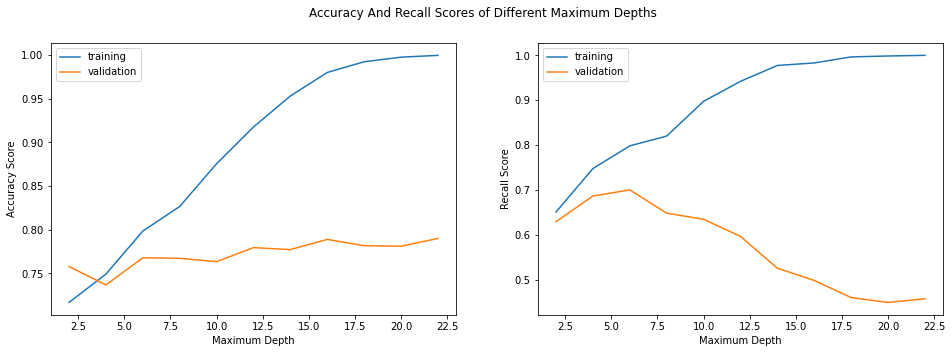

In [14]:
# plot scores
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].plot(depths, train_acc_scores, label="training")
ax[0].plot(depths, val_acc_scores, label="validation")
ax[1].plot(depths, train_recall_scores, label="training")
ax[1].plot(depths, val_recall_scores, label="validation")
ax[0].legend(), ax[0].set_ylabel("Accuracy Score"), ax[0].set_xlabel("Maximum Depth")
ax[1].legend(), ax[1].set_ylabel("Recall Score"), ax[1].set_xlabel("Maximum Depth")
plt.suptitle("Accuracy And Recall Scores of Different Maximum Depths");

An optimal tree depth for the accuracy and recall scores appears to be 6.

In [15]:
# build model with a maximum depth of 6
clf_2 = make_pipeline(OneHotEncoder(use_cat_names=True), DecisionTreeClassifier(max_depth=6, random_state=42))
clf_2.fit(X_train_over, y_train_over)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['Geography', 'Gender'],
                               use_cat_names=True)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=6, random_state=42))])

In [16]:
# print training classification report
print(classification_report(y_train_over, clf_2.predict(X_train_over)))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80      5734
           1       0.80      0.80      0.80      5734

    accuracy                           0.80     11468
   macro avg       0.80      0.80      0.80     11468
weighted avg       0.80      0.80      0.80     11468



In [17]:
# print validation classification report
print(classification_report(y_val, clf_2.predict(X_val)))

              precision    recall  f1-score   support

           0       0.91      0.79      0.84      1433
           1       0.45      0.70      0.55       367

    accuracy                           0.77      1800
   macro avg       0.68      0.74      0.70      1800
weighted avg       0.82      0.77      0.78      1800



The optimized model appears to have less accuracy and f1 scores on the training set, but it can generalize on unseen data than the previous models. As seen in the classification report for the validation set, the model has an accuracy score of 0.77, an f1 score of 0.55, a recall score of 0.70, and a precision score of 0.45. The model's performance in identifying customers that are likely to leave is improved, though precision is slightly reduced.

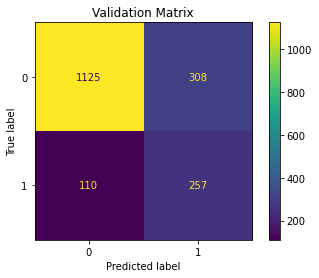

In [18]:
# plot confusion matrix
ConfusionMatrixDisplay.from_estimator(clf_2, X_val, y_val)
plt.title("Validation Matrix");

From the figure above it can be seen that, the model is able to correctly identify 257 out of 367 costumers that left. Also, it was able to identify 1125 out of 1433 customers that did not leave.

In [19]:
# evaluate model on test set
print(classification_report(y_test, clf_2.predict(X_test)))

              precision    recall  f1-score   support

           0       0.93      0.78      0.85       796
           1       0.47      0.76      0.58       204

    accuracy                           0.78      1000
   macro avg       0.70      0.77      0.71      1000
weighted avg       0.83      0.78      0.79      1000



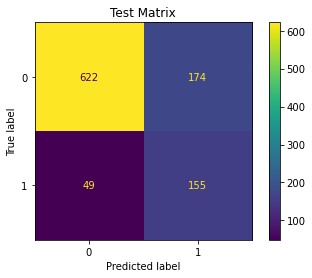

In [20]:
# plot confusion matrix
ConfusionMatrixDisplay.from_estimator(clf_2, X_test, y_test)
plt.title("Test Matrix");

The classification report showed that the model has an accuracy score of 0.78, a recall score of 0.78, and an f1 score of 0.58, respectively on the test set. This further shows that the model will generalize and perform well on unseen data. The confusion matrix also showed that the model was able to identify 155 out of 204 customers that left.

## Ensemble Models
Improving model performance using ensemble methods

In [21]:
# create function that finds optimal number of estimators

def get_estimator_scores(clf, **kwargs):

    train_acc_scores = [] # store Training accuracy score
    train_precision_scores = [] # store Training precision score
    train_recall_scores = [] # store Training recall score
    val_acc_scores = [] # store Validation accuracy score
    val_precision_scores = [] # store Validation precision score
    val_recall_scores = [] # store Validation recall score

    # initialize clf
    dummy_clf = make_pipeline(OneHotEncoder(use_cat_names=True), clf)

    if "n_estimators" in kwargs:
        for estimators in tqdm(kwargs["n_estimators"]):

            # update number of estimators
            dummy_clf[-1].set_params(n_estimators=estimators)
            
            # fit model
            dummy_clf.fit(X_train_over, y_train_over)

            # make predictions
            y_train_pred = dummy_clf.predict(X_train_over)
            val_pred = dummy_clf.predict(X_val)

            # store Training scores
            t_acc = accuracy_score(y_train_over, y_train_pred)
            t_precision = precision_score(y_train_over, y_train_pred)
            t_recall = recall_score(y_train_over, y_train_pred)
            train_acc_scores.append(t_acc)
            train_precision_scores.append(t_precision)
            train_recall_scores.append(t_recall)

            # store Validation scores
            v_acc = accuracy_score(y_val, val_pred)
            v_precision = precision_score(y_val, val_pred)
            v_recall = recall_score(y_val, val_pred)
            val_acc_scores.append(v_acc)
            val_precision_scores.append(v_precision)
            val_recall_scores.append(v_recall)
            
        return  train_acc_scores, train_precision_scores, train_recall_scores, val_acc_scores, val_precision_scores, val_recall_scores

# create function that plots result

def plot_results(x, y):

    train_acc_scores, train_precision_scores, train_recall_scores, val_acc_scores, val_precision_scores, val_recall_scores = y

    fig, ax=plt.subplots(1, 3, figsize=(20, 5))
    ax1, ax2, ax3 = ax
    
    ax1.plot(x, train_acc_scores, label="Training")
    ax1.plot(x, val_acc_scores, label="Validation")
    ax1.set_xlabel("Number of Estimators"), ax1.set_ylabel("Accuracy Score"), ax1.legend(loc="best")

    ax2.plot(x, train_precision_scores, label="Training")
    ax2.plot(x, val_precision_scores, label="Validation")
    ax2.set_xlabel("Number of Estimators"), ax2.set_ylabel("Precision Score"), ax2.legend(loc="best")

    ax3.plot(x, train_recall_scores, label="Training")
    ax3.plot(x, val_recall_scores, label="Validation")
    ax3.set_xlabel("Number of Estimators"), ax3.set_ylabel("Recall Score"), ax3.legend(loc="best")

    plt.suptitle("Evaluation Metrics of Different Tree Depths")

    return

### Random Forest Classifier

In [22]:
# get scores
rf = RandomForestClassifier(max_depth=6, random_state=42)
n_estimators = range(10, 210, 10)
scores = get_estimator_scores(rf, n_estimators=n_estimators)

100%|██████████| 20/20 [01:30<00:00,  4.51s/it]


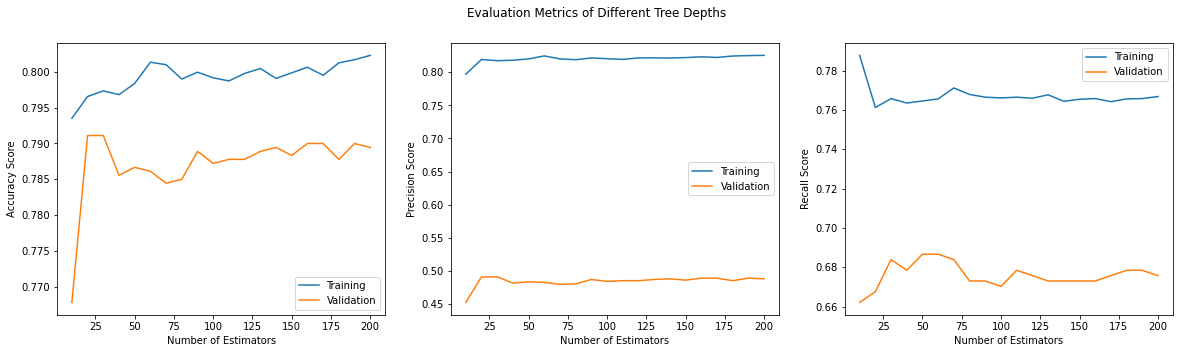

In [23]:
plot_results(n_estimators, scores)

From the figure above, an optimal number of estimator for the random forest classifier appears to be 30. The precision score slightly increased, but recall score is reduced. Though random forest classifier's precision score is better than the decision tree classifier's precision score, the decision tree classifier has a better recall score.

### Gradient Boossting Classifier

In [24]:
gb = GradientBoostingClassifier(max_depth=6, random_state=42)
scores = get_estimator_scores(gb, n_estimators=n_estimators)

100%|██████████| 20/20 [04:35<00:00, 13.78s/it]


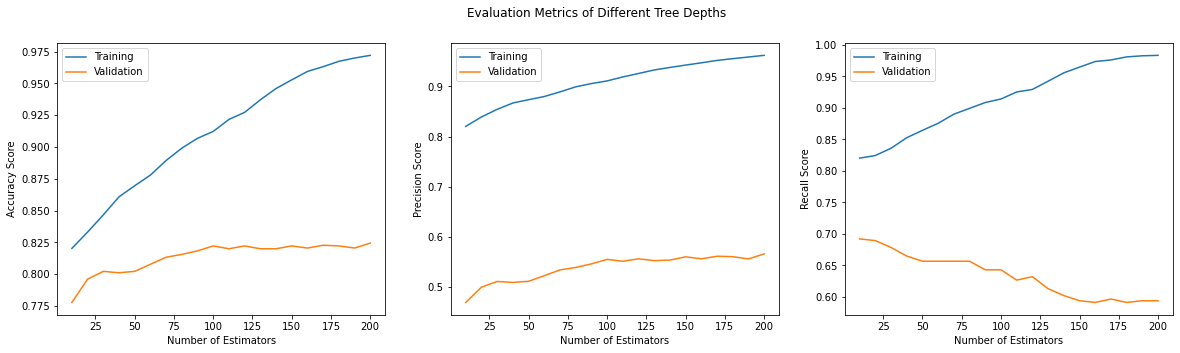

In [25]:
plot_results(n_estimators, scores)

An optimal number of estimators for the gradient boosting classifier appears to be 25, precision score is also improved but recall score is reduced. Since recall is reduced in both the random forest and gradient boosting classifiers, the previous decision tree model is the best performing model because it has the highest recall score.

# Feature Importances

In [26]:
# visualize important features learned by the algorithm
importances = clf_2[-1].feature_importances_
features = clf_2[-1].feature_names_in_
feat_imp = pd.Series(importances, index=features).sort_values()

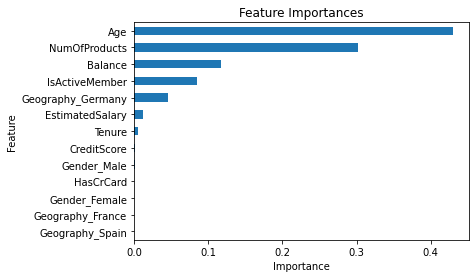

In [27]:
# plot feature importances
feat_imp.plot(kind="barh")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importances");

From the figure above, it can be seen that a customer's age feature is the most important feature in determining if a customer will leave or stay. Other top important features include number of products used, account balance, customer activity, and location.

# Dashboard Development
In order to convince stakeholders of the model's performance, an interactive dashboard will built to adjust the probability threshold of the model. This will allow stakeholders see how precision and recall affects the total amount likely to be spent on customer aquisition and customer retention.

## Save Model

In [28]:
# split data to training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# resample training set
ros = RandomOverSampler(random_state=42)
X_train_over, y_train_over = ros.fit_resample(X_train, y_train)

# build model
clf = make_pipeline(OneHotEncoder(use_cat_names=True), DecisionTreeClassifier(max_depth=6, random_state=42))
clf.fit(X_train_over, y_train_over)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['Geography', 'Gender'],
                               use_cat_names=True)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=6, random_state=42))])

In [29]:
# check model result
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.93      0.76      0.84      1593
           1       0.45      0.77      0.57       407

    accuracy                           0.76      2000
   macro avg       0.69      0.77      0.70      2000
weighted avg       0.83      0.76      0.78      2000



In [30]:
# save model
joblib.dump(clf, "./app/model.pkl")

# save test set
test_data = pd.concat([X_test, y_test], axis=1)
test_data.to_csv("./app/data/test_data")